In [2]:
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
from torch import optim
import numpy as np
from PIL import Image
import random
from scipy import ndimage, io, misc
import shutil  
import torchvision.models as models
from tqdm import tqdm
from xml.dom import minidom

In [208]:
test_list = io.loadmat('test_list.mat')['file_list']
train_list = io.loadmat('train_list.mat')['file_list']

In [206]:
for folder in os.listdir('Images'):
    os.makedirs("train/"+folder.split("\\")[-1].split("-",1)[-1])
    os.makedirs("test/"+folder.split("\\")[-1].split("-",1)[-1])

In [ ]:
# original images
def move_data_files(image_list, new_folder):
    for file in image_list:
        if os.path.exists('Images/'+file[0][0]):
            folder_name = file[0][0].split("/")[0].split("-",1)[-1]
            file_name = file[0][0].split("/")[1]
            shutil.move('Images/'+file[0][0],new_folder+'/'+folder_name+'/'+file_name)
        elif not os.path.exists(new_folder+'/'+file[0][0]):
           print('%s does not exist, it may be missing' % os.path.exists('./images/'+file[0][0]))
    return [new_folder+'/'+d for d in sorted(os.listdir(new_folder)) if os.path.isdir(os.path.join(new_folder, d))]

In [3]:
# crop images
def crop_image(image_list,new_folder):
    count = 0
    for file in image_list:
        if os.path.exists('Images/'+file[0][0]):
            folder_name = file[0][0].split("/")[0].split("-",1)[-1]
            file_name = file[0][0].split("/")[1]
            annon_xml = minidom.parse('Annotation/'+file[0][0].split('.')[0])
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            img = cv2.imread('Images/'+file[0][0])
            cropped_img = img[ymin:ymax,xmin:xmax,:]
            cv2.imwrite(new_folder+'/'+folder_name+'/'+file_name,cropped_img)
 

In [ ]:
crop_image(train_list, 'train1')
crop_image(test_list, 'test1')

In [ ]:
test_folders = move_data_files(test_list, 'test')
train_folders = move_data_files(train_list, 'train')

In [293]:
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, 3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
class Unet(nn.Module):
    def __init__(self,input_channel,output_channel):
        super().__init__()
        self.conv1 = DoubleConv(input_channel, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,output_channel, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merged6 = torch.cat([up_6, c4], 1)
        c6=self.conv6(merged6)
        up_7=self.up7(c6)
        merged7 = torch.cat([up_7, c3], 1)
        c7=self.conv7(merged7)
        up_8=self.up8(c7)
        merged8 = torch.cat([up_8, c2], 1)
        c8=self.conv8(merged8)
        up_9=self.up9(c8)
        merged9=torch.cat([up_9,c1], 1)
        c9=self.conv9(merged9)
        c10=self.conv10(c9)
        output = nn.Sigmoid()(c10)
        return output

In [ ]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=120):
        super(VGGNet, self).__init__()
        net = models.vgg16_bn()
        pre=torch.load('vgg16_bn-6c64b313.pth')
        net.load_state_dict(pre)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [234]:
transform=T.Compose([T.RandomResizedCrop(224),
                    T.RandomHorizontalFlip(),
                    T.Resize((224,224)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [137]:
batch_size = 16
epoch = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),0.0001)
train_datasets   = torchvision.datasets.ImageFolder('train1',transform)
train_dataloader = torch.utils.data.DataLoader(train_datasets , batch_size=batch_size, shuffle=True)

In [138]:
test_datasets   = torchvision.datasets.ImageFolder('test1',transform)
test_dataloader = torch.utils.data.DataLoader(test_datasets , batch_size=100)

In [ ]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
best_test_accuracy = 0
for epoch in range(epoch):
    print('epoch {}'.format(epoch + 1))
    train_loss = 0.
    train_acc = 0.
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        pred = torch.max(out, 1)[1]
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
    train_datasets)), train_acc / (len(train_datasets))))
    train_loss_list.append(train_loss / (len(train_datasets)))
    train_accuracy_list.append(train_acc / (len(train_datasets)))
    model.eval()
    with torch.no_grad():
        test_loss = 0.
        test_acc = 0.
        for batch_x, batch_y in test_dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            out = model(batch_x)
            loss = loss_func(out, batch_y)
            test_loss += loss.item()
            pred = torch.max(out, 1)[1]
            test_correct = (pred == batch_y).sum()
            test_acc += test_correct.item()
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(test_loss / (len(
        test_datasets)), test_acc / (len(test_datasets))))
        test_loss_list.append(test_loss / (len(test_datasets)))
        test_accuracy_list.append(test_acc / (len(test_datasets)))
        if (test_acc / (len(test_datasets))) > best_test_accuracy:
            best_test_accuracy = test_acc / (len(test_datasets))
            torch.save(model.state_dict(),"weight_1_best.pth")
            

(0, 1)

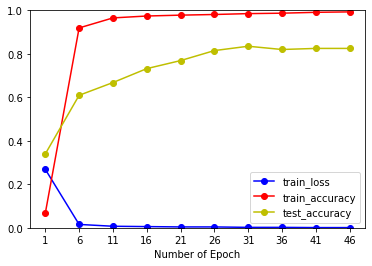

In [292]:
epoch = []
for i in range(1,51,5):
    epoch.append(str(i))

plt.plot(epoch, train_loss_list[::5], '-b', marker='o',label='train_loss')
plt.plot(epoch, train_accuracy_list[::5], '-r',marker='o',label='train_accuracy')
plt.plot(epoch, test_accuracy_list[::5], '-y',marker='o',label='test_accuracy')
plt.xlabel("Number of Epoch")
plt.legend(loc='lower right')
plt.ylim(0, 1)

In [141]:
model.eval()
model.load_state_dict(torch.load('weight_1_best.pth'))
test_datasets   = torchvision.datasets.ImageFolder('test1',transform)
test_dataloader = torch.utils.data.DataLoader(test_datasets , batch_size=1)
inv_map = {v: k for k, v in test_datasets.class_to_idx.items()}

In [110]:
res = np.zeros(120)
total = np.zeros(120)
with torch.no_grad():
    count = 0
    for batch_x, batch_y in test_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        out = model(batch_x)
        pred = torch.max(out, 1)[1]
        correct = (pred == batch_y).item()
        total[batch_y.item()] = total[batch_y.item()] + 1
        if correct:
            res[batch_y.item()] = res[batch_y.item()] + 1

In [142]:
best_10 = []
best_10_acc = []
worst_10 = []
worst_10_acc = []
accuarcy_per_group = np.round(res/total,4)
sorted_ascend = accuarcy_per_group.argsort()
sorted_descend = accuarcy_per_group.argsort()[::-1]

for i in range(10):
    best_10.append(inv_map[sorted_descend[i]])
    best_10_acc.append(accuarcy_per_group[sorted_descend[i]])
    worst_10.append(inv_map[sorted_ascend[i]])
    worst_10_acc.append(accuarcy_per_group[sorted_ascend[i]])
print(best_10)
print(best_10_acc)
print(worst_10)
print(worst_10_acc)

['clumber', 'Norwegian_elkhound', 'Bernese_mountain_dog', 'Irish_water_spaniel', 'keeshond', 'chow', 'Saint_Bernard', 'Sussex_spaniel', 'komondor', 'Leonberg']
[0.94, 0.9271, 0.9237, 0.92, 0.8966, 0.8958, 0.8857, 0.8824, 0.8704, 0.8636]
['Siberian_husky', 'Appenzeller', 'collie', 'Great_Dane', 'miniature_poodle', 'Rhodesian_ridgeback', 'toy_poodle', 'standard_schnauzer', 'Staffordshire_bullterrier', 'Yorkshire_terrier']
[0.2935, 0.3333, 0.3396, 0.3571, 0.3636, 0.3889, 0.3922, 0.4, 0.4182, 0.4219]


(0, 1)

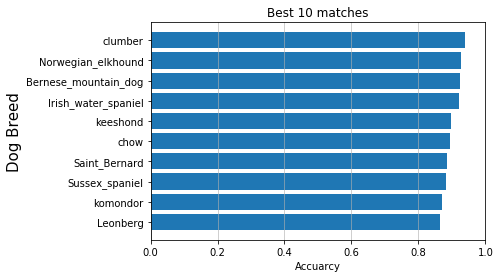

In [230]:
#visualize best 10 matches
plt.barh(best_10[::-1], best_10_acc[::-1]) 
plt.grid(axis='x', alpha=0.75)
plt.yticks(x, best_10[::-1])
plt.ylabel('Dog Breed',fontsize=15)
plt.xlabel('Accuarcy',fontsize=10)
plt.title("Best 10 matches")
plt.xlim(0, 1)

(0, 1)

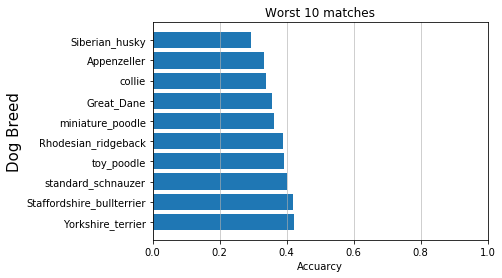

In [232]:
#visualize worst 10 matches
plt.barh(worst_10[::-1], worst_10_acc[::-1]) 
plt.grid(axis='x', alpha=0.75)
plt.yticks(x, worst_10[::-1])
plt.ylabel('Dog Breed',fontsize=15)
plt.xlabel('Accuarcy',fontsize=10)
plt.title("Worst 10 matches")
plt.xlim(0, 1)

In [295]:
model_unet = Unet(3,1).to(device)
model_unet.load_state_dict(torch.load('weights_transfer_2_1.pth'))

<All keys matched successfully>

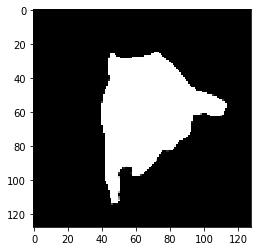

In [380]:
transform1 = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
img = Image.open("test/dingo/n02115641_4563.jpg").convert('RGB')
img_trans = transform1(img).to(device)
mask = model_unet(img_trans.unsqueeze(0))
img_trans_vgg = transform(img).to(device)
out = model(img_trans_vgg)
breed = inv_map[torch.max(out, 1)[1].item()]
plt.imshow(mask.cpu().detach().numpy().squeeze(),cmap="gray")

In [381]:
def draw_line(image,mask,breed):
    outputs = np.array(mask.cpu().detach().numpy().squeeze())*255
    y = np.copy(image.permute(1, 2, 0))
    outputs_canny = cv2.Canny(np.uint8(outputs), 50, 120)
    y[outputs_canny == 255] = [1,0,0]
    plt.imshow(y)
    plt.title("Predicated Breed:" + breed)
    plt.savefig('2.jpg',dpi=1000)

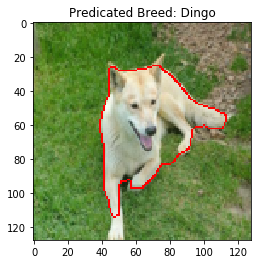

In [382]:
draw_line(transform1(img),mask,breed)